In [10]:
"""
Phase 1C: Salt Repository Data Exploration
Understanding patterns, distributions, and data quality
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

In [11]:
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Better display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("BugSage Data Exploration (Salt)")
print("=" * 60)

BugSage Data Exploration (Salt)


In [12]:
# Loading the data
df = pd.read_csv('../data/interim/salt_commits_raw.csv')

print(f"\nLoaded {len(df):,} records")
print(f"\nDataset Infor: ")
print(f"    Shape: {df.shape}")
print(f"    Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Converting commit_time to datetime
df['commit_time'] = pd.to_datetime(df['commit_time'])

# Basic Info
print(f"\nBasic Stats:")
print(f"  Unique commits: {df['commit_sha'].nunique():,}")
print(f"  Unique authors: {df['author'].nunique():,}")
print(f"  Unique files: {df['file_path'].nunique():,}")
print(f"  Date range: {df['commit_time'].min().date()} to {df['commit_time'].max().date()}")

# Showing columns
print(f"\nColumns:")
for col in df.columns:
    print(f"  - {col:20s} ({df[col].dtype})")


Loaded 6,620 records

Dataset Infor: 
    Shape: (6620, 16)
    Memory: 56.24 MB

Basic Stats:
  Unique commits: 4,156
  Unique authors: 412
  Unique files: 1,560
  Date range: 2020-01-02 to 2025-09-24

Columns:
  - project              (object)
  - repo                 (object)
  - commit_sha           (object)
  - parent_sha           (object)
  - commit_time          (datetime64[ns])
  - author               (object)
  - author_email         (object)
  - message              (object)
  - file_path            (object)
  - files_changed        (int64)
  - insertions           (int64)
  - deletions            (int64)
  - hunks_count          (int64)
  - issue_id             (float64)
  - is_bugfix            (bool)
  - patch_text           (object)


In [13]:
# Displaying first few records
print("\nSample Records (first 3):")
display(df[['commit_sha', 'author', 'commit_time', 'message', 
            'file_path', 'insertions', 'deletions', 'is_bugfix']].head(3))

# Displaying one full record
print("\nOne Complete Record:")
sample = df.iloc[0]
for col in df.columns:
    if col != 'patch_text':  # Skip patch for readability
        print(f"  {col:20s}: {sample[col]}")


Sample Records (first 3):


,commit_sha,author,commit_time,message,file_path,insertions,deletions,is_bugfix
0,fe49c7cf3cc17433ebf1de7370d9d9995173756a,Daniel A. Wozniak,2025-09-24 12:54:12,Revert part of test fix,salt/modules/git.py,0,6,True
1,1d57a26507c6faeafbd0bdb6914f4e48af2f5a23,Daniel A. Wozniak,2025-09-20 02:31:57,Check git test fix,salt/modules/git.py,4,0,True
2,2189610307d2a5aced4312ee3b21c511196237cd,Juliano Naves,2025-09-17 03:22:24,fix,salt/transport/tcp.py,9,4,True



One Complete Record:
  project             : salt
  repo                : salt
  commit_sha          : fe49c7cf3cc17433ebf1de7370d9d9995173756a
  parent_sha          : 49f56841c3a38d5f387e5c5f58148843f067d37e
  commit_time         : 2025-09-24 12:54:12
  author              : Daniel A. Wozniak
  author_email        : daniel.wozniak@broadcom.com
  message             : Revert part of test fix
  file_path           : salt/modules/git.py
  files_changed       : 1
  insertions          : 0
  deletions           : 6
  hunks_count         : 3
  issue_id            : nan
  is_bugfix           : True


In [14]:
# Check for missing values
print("\nMissing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing': missing.values,
    'Percentage': missing_pct.values
})

missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)

if len(missing_df) > 0:
    display(missing_df)
else:
    print("  No missing values!")

# Check patch_text specifically
empty_patches = df['patch_text'].isna().sum()
print(f"\n  Patches with data: {len(df) - empty_patches:,} / {len(df):,}")


Missing Values:


,Column,Missing,Percentage
13,issue_id,6270,94.71



  Patches with data: 6,620 / 6,620



Temporal Analysis:
  Total months: 69
  Avg commits/month: 60.2
  Peak month: 2021-02 (293 commits)


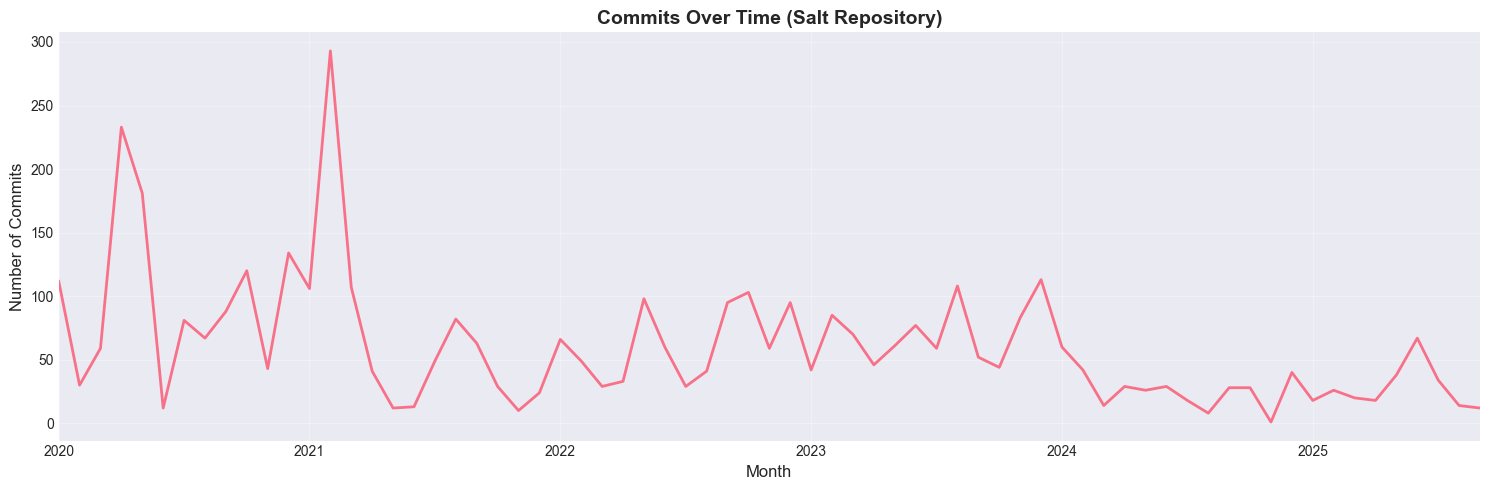


Commits by Year:
  2020: 1,160 commits
  2021: 829 commits
  2022: 757 commits
  2023: 840 commits
  2024: 323 commits
  2025: 247 commits


In [15]:
# Commits over time
print("\nTemporal Analysis:")

# Extract year-month
df['year_month'] = df['commit_time'].dt.to_period('M')

# Count commits per month
commits_per_month = df.groupby('year_month')['commit_sha'].nunique()

print(f"  Total months: {len(commits_per_month)}")
print(f"  Avg commits/month: {commits_per_month.mean():.1f}")
print(f"  Peak month: {commits_per_month.idxmax()} ({commits_per_month.max()} commits)")

# Plot
fig, ax = plt.subplots(figsize=(15, 5))
commits_per_month.plot(kind='line', ax=ax, linewidth=2)
ax.set_title('Commits Over Time (Salt Repository)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Commits', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Year-over-year
commits_per_year = df.groupby(df['commit_time'].dt.year)['commit_sha'].nunique()
print(f"\nCommits by Year:")
for year, count in commits_per_year.items():
    print(f"  {year}: {count:,} commits")


Author Analysis:
  Total authors: 412

Top 10 Contributors:
   1. Pedro Algarvio                 - 1000 commits (24.06%)
   2. Daniel A. Wozniak              -  440 commits (10.59%)
   3. twangboy                       -  163 commits ( 3.92%)
   4. Gareth J. Greenaway            -  155 commits ( 3.73%)
   5. David Murphy                   -  155 commits ( 3.73%)
   6. Megan Wilhite                  -  105 commits ( 2.53%)
   7. Twangboy                       -  101 commits ( 2.43%)
   8. Pablo Suárez Hernández         -   97 commits ( 2.33%)
   9. MKLeb                          -   92 commits ( 2.21%)
  10. cmcmarrow                      -   91 commits ( 2.19%)


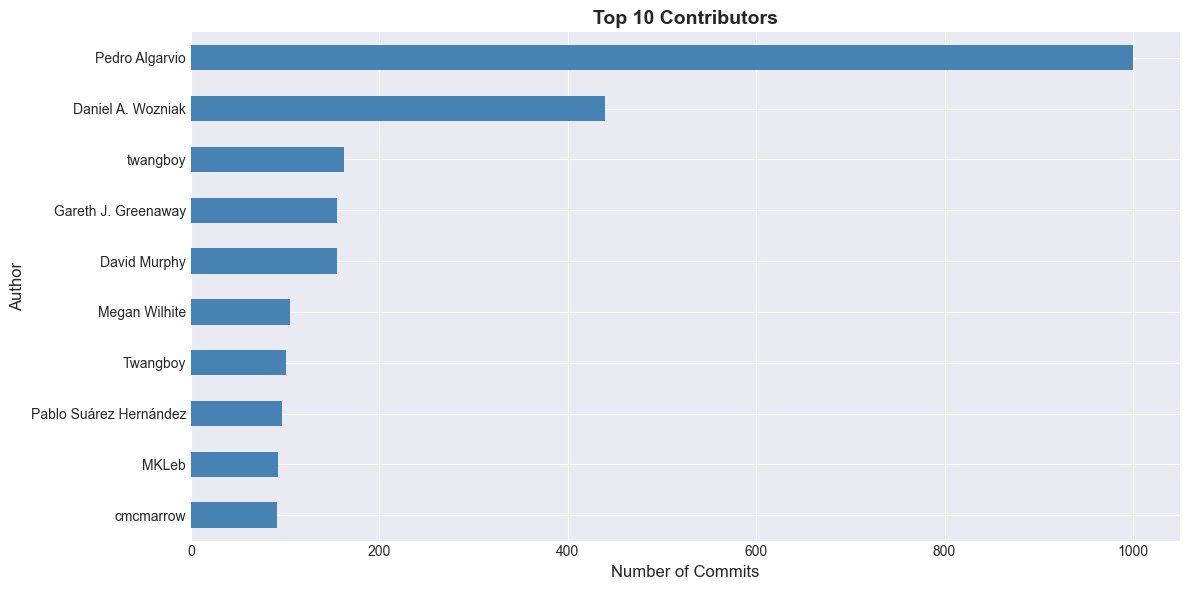

In [16]:
# Author statistics
print("\nAuthor Analysis:")

unique_authors = df['author'].nunique()
print(f"  Total authors: {unique_authors:,}")

# Top authors by commits
top_authors = df.groupby('author')['commit_sha'].nunique().sort_values(ascending=False).head(10)

print(f"\nTop 10 Contributors:")
for i, (author, count) in enumerate(top_authors.items(), 1):
    pct = count / df['commit_sha'].nunique() * 100
    print(f"  {i:2d}. {author:30s} - {count:4d} commits ({pct:5.2f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
top_authors.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 10 Contributors', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Commits', fontsize=12)
ax.set_ylabel('Author', fontsize=12)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


File Analysis:
  Total unique files: 1,560

Most Frequently Changed Files:
   1. noxfile.py                                                   -  135 changes
   2. tools/ci.py                                                  -  129 changes
   3. salt/transport/tcp.py                                        -   81 changes
   4. salt/states/file.py                                          -   79 changes
   5. tools/vm.py                                                  -   77 changes
   6. salt/minion.py                                               -   73 changes
   7. salt/transport/zeromq.py                                     -   71 changes
   8. salt/modules/cmdmod.py                                       -   70 changes
   9. salt/grains/core.py                                          -   62 changes
  10. salt/modules/virt.py                                         -   61 changes
  11. setup.py                                                     -   54 changes
  12. tools/pkgrepo.py

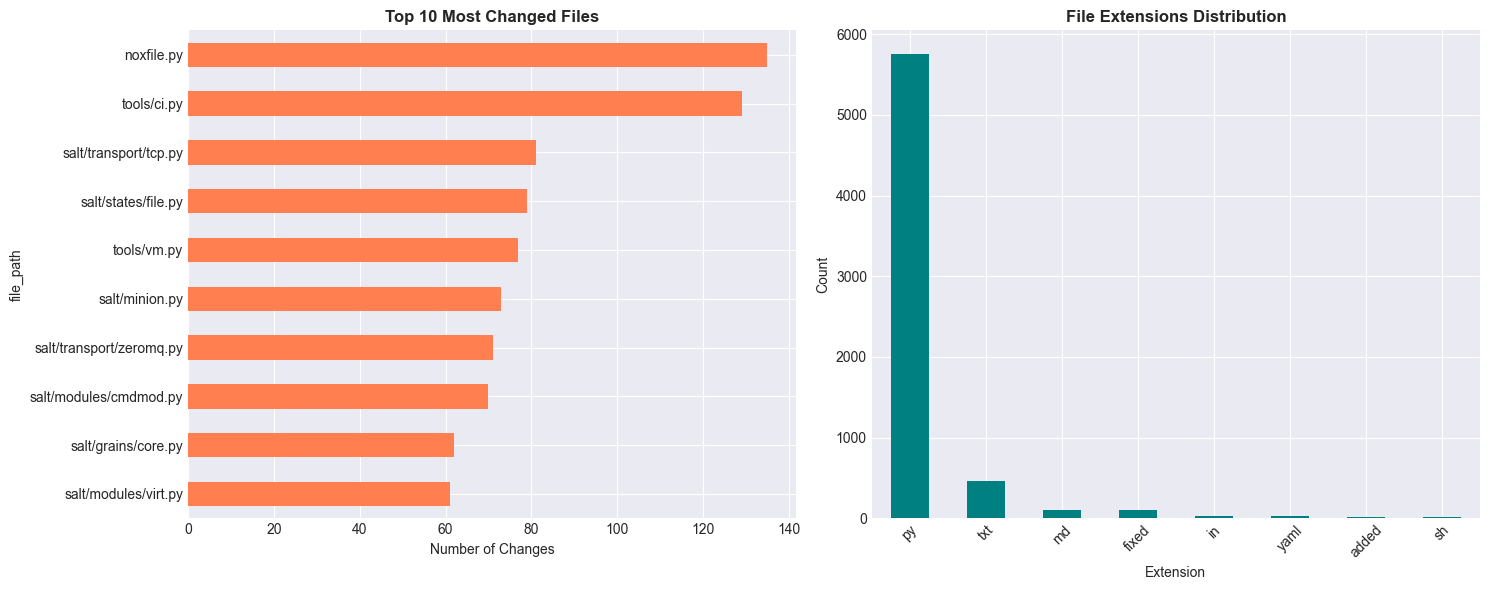

In [17]:
# Most changed files
print("\nFile Analysis:")

total_files = df['file_path'].nunique()
print(f"  Total unique files: {total_files:,}")

# Top files by change frequency
top_files = df['file_path'].value_counts().head(15)

print(f"\nMost Frequently Changed Files:")
for i, (file, count) in enumerate(top_files.items(), 1):
    print(f"  {i:2d}. {file:60s} - {count:4d} changes")

# File extensions
df['extension'] = df['file_path'].str.extract(r'\.([^.]+)$')[0]
ext_counts = df['extension'].value_counts().head(10)

print(f"\nFile Extensions:")
for ext, count in ext_counts.items():
    pct = count / len(df) * 100
    print(f"  .{ext:10s}: {count:5d} ({pct:5.2f}%)")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Top files
top_files.head(10).plot(kind='barh', ax=ax1, color='coral')
ax1.set_title('Top 10 Most Changed Files', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Changes')
ax1.invert_yaxis()

# Extensions
ext_counts.head(8).plot(kind='bar', ax=ax2, color='teal')
ax2.set_title('File Extensions Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Extension')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Commit Size Analysis:
  Avg insertions: 40.0 lines
  Avg deletions: 35.3 lines
  Avg total changes: 75.3 lines
  Median total changes: 19.0 lines

Size Distribution:
  Tiny (0-10)         :  2551 (38.53%)
  Small (10-50)       :  1984 (29.97%)
  Medium (50-100)     :   755 (11.40%)
  Large (100-200)     :   567 ( 8.56%)
  Very Large (200-500):   565 ( 8.53%)
  Huge (500+)         :   198 ( 2.99%)


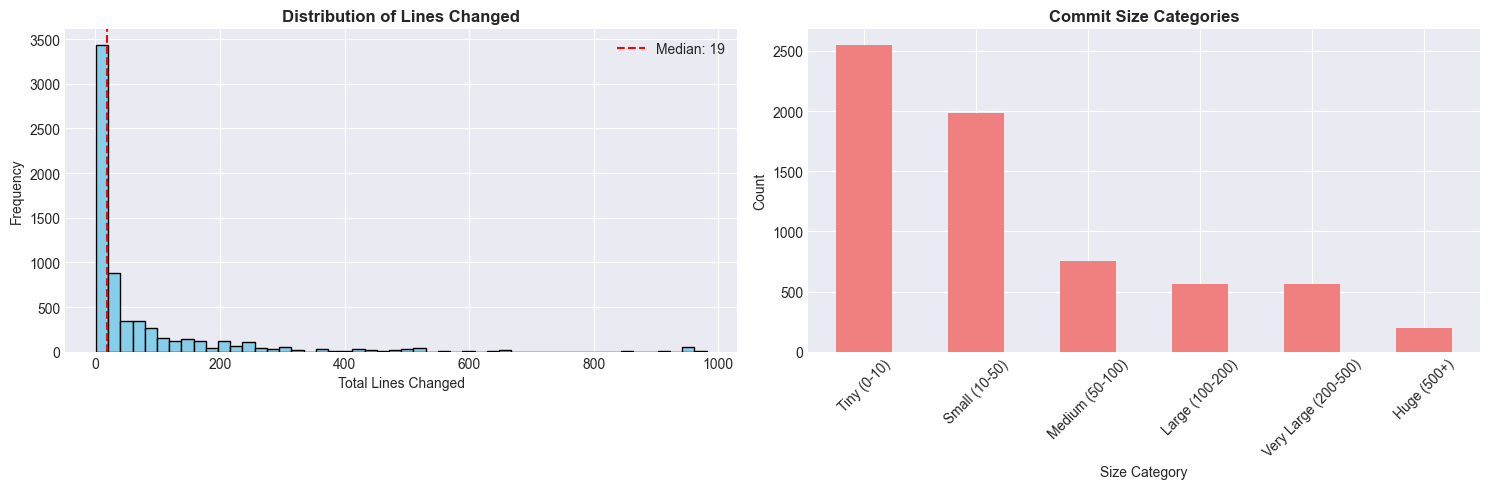

In [18]:
# Lines changed distribution
print("\nCommit Size Analysis:")

df['total_lines'] = df['insertions'] + df['deletions']
df['net_lines'] = df['insertions'] - df['deletions']

print(f"  Avg insertions: {df['insertions'].mean():.1f} lines")
print(f"  Avg deletions: {df['deletions'].mean():.1f} lines")
print(f"  Avg total changes: {df['total_lines'].mean():.1f} lines")
print(f"  Median total changes: {df['total_lines'].median():.1f} lines")

# Distribution
print(f"\nSize Distribution:")
size_bins = [0, 10, 50, 100, 200, 500, 1000]
df['size_category'] = pd.cut(df['total_lines'], bins=size_bins, 
                               labels=['Tiny (0-10)', 'Small (10-50)', 'Medium (50-100)', 
                                      'Large (100-200)', 'Very Large (200-500)', 'Huge (500+)'])

size_dist = df['size_category'].value_counts().sort_index()
for cat, count in size_dist.items():
    pct = count / len(df) * 100
    print(f"  {cat:20s}: {count:5d} ({pct:5.2f}%)")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
df['total_lines'].hist(bins=50, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Lines Changed', fontsize=12, fontweight='bold')
ax1.set_xlabel('Total Lines Changed')
ax1.set_ylabel('Frequency')
ax1.axvline(df['total_lines'].median(), color='red', linestyle='--', label=f'Median: {df["total_lines"].median():.0f}')
ax1.legend()

# Size categories
size_dist.plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Commit Size Categories', fontsize=12, fontweight='bold')
ax2.set_xlabel('Size Category')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Bugfix Analysis:
  Bugfix commits: 2,111 (31.89%)
  Non-bugfix commits: 4,509 (68.11%)

Bugfix vs Non-Bugfix Characteristics:


,insertions,deletions,total_lines,files_changed,hunks_count
Non-Bugfix,43.86,39.48,83.34,6.02,15.23
Bugfix,31.76,26.27,58.03,7.72,18.48



Issue Tracking:
  Commits with issue IDs: 350 (5.29%)
  Commits without issues: 6,270 (94.71%)


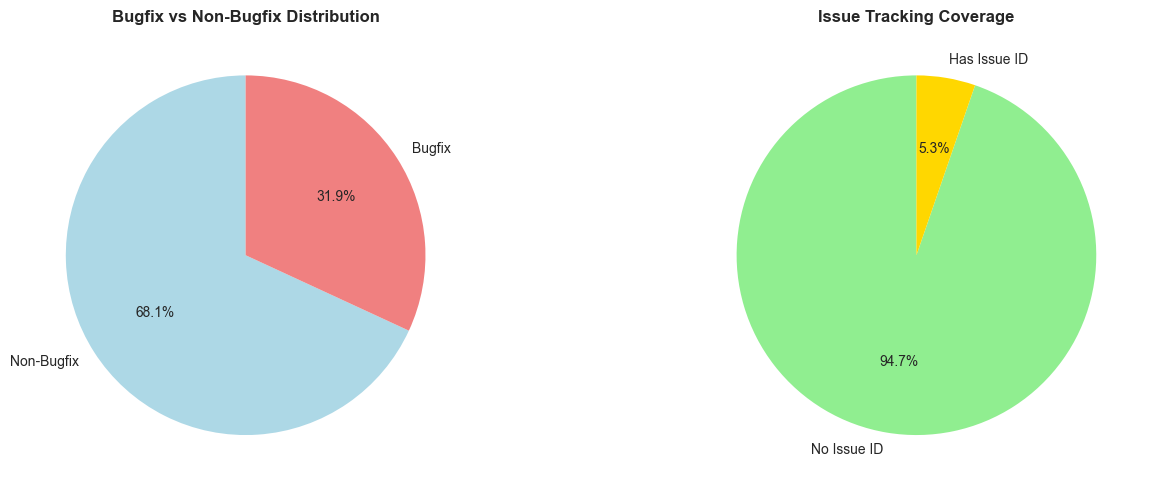

In [19]:
# Bugfix commits
print("\nBugfix Analysis:")

bugfix_count = df['is_bugfix'].sum()
bugfix_pct = bugfix_count / len(df) * 100

print(f"  Bugfix commits: {bugfix_count:,} ({bugfix_pct:.2f}%)")
print(f"  Non-bugfix commits: {len(df) - bugfix_count:,} ({100-bugfix_pct:.2f}%)")

# Bugfix vs non-bugfix characteristics
print(f"\nBugfix vs Non-Bugfix Characteristics:")

comparison = df.groupby('is_bugfix').agg({
    'insertions': 'mean',
    'deletions': 'mean',
    'total_lines': 'mean',
    'files_changed': 'mean',
    'hunks_count': 'mean'
}).round(2)

comparison.index = ['Non-Bugfix', 'Bugfix']
display(comparison)

# Issue IDs
issue_count = df['issue_id'].notna().sum()
issue_pct = issue_count / len(df) * 100

print(f"\nIssue Tracking:")
print(f"  Commits with issue IDs: {issue_count:,} ({issue_pct:.2f}%)")
print(f"  Commits without issues: {len(df) - issue_count:,} ({100-issue_pct:.2f}%)")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bugfix distribution
bugfix_labels = ['Non-Bugfix', 'Bugfix']
bugfix_values = [len(df) - bugfix_count, bugfix_count]
ax1.pie(bugfix_values, labels=bugfix_labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
ax1.set_title('Bugfix vs Non-Bugfix Distribution', fontsize=12, fontweight='bold')

# Issue tracking
issue_labels = ['No Issue ID', 'Has Issue ID']
issue_values = [len(df) - issue_count, issue_count]
ax2.pie(issue_values, labels=issue_labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'gold'])
ax2.set_title('Issue Tracking Coverage', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
# Message analysis
print("\nCommit Message Analysis:")

# Average message length
df['message_length'] = df['message'].str.len()
print(f"  Avg message length: {df['message_length'].mean():.1f} characters")
print(f"  Median message length: {df['message_length'].median():.0f} characters")

# Common keywords
keywords = ['fix', 'bug', 'add', 'update', 'remove', 'change', 'improve', 'refactor', 'test', 'doc']

print(f"\nKeyword Frequency in Messages:")
for keyword in keywords:
    count = df['message'].str.lower().str.contains(keyword).sum()
    pct = count / len(df) * 100
    print(f"  '{keyword:10s}': {count:5d} ({pct:5.2f}%)")

# Sample messages
print(f"\nSample Bugfix Messages:")
bugfix_msgs = df[df['is_bugfix']]['message'].head(5)
for i, msg in enumerate(bugfix_msgs, 1):
    print(f"  {i}. {msg[:80]}...")

print(f"\nSample Non-Bugfix Messages:")
nonbugfix_msgs = df[~df['is_bugfix']]['message'].head(5)
for i, msg in enumerate(nonbugfix_msgs, 1):
    print(f"  {i}. {msg[:80]}...")


Commit Message Analysis:
  Avg message length: 84.6 characters
  Median message length: 48 characters

Keyword Frequency in Messages:
  'fix       ':  1829 (27.63%)
  'bug       ':   117 ( 1.77%)
  'add       ':  1099 (16.60%)
  'update    ':   434 ( 6.56%)
  'remove    ':   522 ( 7.89%)
  'change    ':   489 ( 7.39%)
  'improve   ':    33 ( 0.50%)
  'refactor  ':    46 ( 0.69%)
  'test      ':   388 ( 5.86%)
  'doc       ':   606 ( 9.15%)

Sample Bugfix Messages:
  1. Revert part of test fix...
  2. Check git test fix...
  3. fix...
  4. Fix typo...
  5. Fix polling timeouts...

Sample Non-Bugfix Messages:
  1. Use the name instead of the description to identify interfaces...
  2. Hold on to send/recv socket reference.

Grab a reference to the send/recv socket...
  3. Use a tornado queue to reduce wait times in send recieve method...
  4. Refactor send recv to avoid race conditions and limit memory usage...
  5. Ensure "test" returns only boolean values...


In [21]:
# Final data quality report
print("\n" + "="*60)
print("DATA QUALITY SUMMARY")
print("="*60)

print(f"\nDataset Size:")
print(f"  Total records: {len(df):,}")
print(f"  Unique commits: {df['commit_sha'].nunique():,}")
print(f"  Unique files: {df['file_path'].nunique():,}")
print(f"  Unique authors: {df['author'].nunique():,}")

print(f"\nDate Coverage:")
print(f"  From: {df['commit_time'].min().date()}")
print(f"  To: {df['commit_time'].max().date()}")
print(f"  Duration: {(df['commit_time'].max() - df['commit_time'].min()).days} days")

print(f"\nData Quality:")
print(f"  Complete records: {len(df) - df.isnull().any(axis=1).sum():,} ({(len(df) - df.isnull().any(axis=1).sum()) / len(df) * 100:.1f}%)")
print(f"  Bugfix labels: {bugfix_count:,} ({bugfix_pct:.1f}%)")
print(f"  Issue IDs: {issue_count:,} ({issue_pct:.1f}%)")

print(f"\nCommit Characteristics:")
print(f"  Avg lines/commit: {df['total_lines'].mean():.1f}")
print(f"  Avg files/commit: {df.groupby('commit_sha')['file_path'].nunique().mean():.1f}")
print(f"  Avg hunks/commit: {df['hunks_count'].mean():.1f}")

print(f"  This dataset is high quality and ready for severity labeling.")
print(f"  We have good temporal coverage (2020-2025)")
print(f"  We have diverse commits (bugfixes and non-bugfixes)")
print(f"  We have enough data (6,620 records) for training")

print("\n" + "="*60)


DATA QUALITY SUMMARY

Dataset Size:
  Total records: 6,620
  Unique commits: 4,156
  Unique files: 1,560
  Unique authors: 412

Date Coverage:
  From: 2020-01-02
  To: 2025-09-24
  Duration: 2092 days

Data Quality:
  Complete records: 349 (5.3%)
  Bugfix labels: 2,111 (31.9%)
  Issue IDs: 350 (5.3%)

Commit Characteristics:
  Avg lines/commit: 75.3
  Avg files/commit: 1.6
  Avg hunks/commit: 16.3
  This dataset is high quality and ready for severity labeling.
  We have good temporal coverage (2020-2025)
  We have diverse commits (bugfixes and non-bugfixes)
  We have enough data (6,620 records) for training

